In [2]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import glob
import cv2
from matplotlib.pyplot import figure
%matplotlib inline

In [ ]:

#Config
s_thresh=(180, 255)
sx_thresh=(30, 120)
labl = (0,95,155)
labh = (255,160,255)
l_thresh = (40, 255)
    
    
def equalize(img):
    #clahe.apply(img)
    H, S, V = cv2.split(cv2.cvtColor(img, cv2.COLOR_BGR2HSV))
    eq_V = cv2.equalizeHist(V)
    #eq_V = clahe.apply(V)
    eq_image = cv2.cvtColor(cv2.merge([H, S, eq_V]), cv2.COLOR_HSV2RGB)
    return eq_image


def apply_sobel_x(channel):
    # Sobel x
    sobelx = cv2.Sobel(channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    return sxbinary

def to_binary_img(img):
    #img = adjust_gamma(img,gamma=.5)
    # Convert to HLS color space and separate the V channel
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    # Sobel x
    sxbinary = apply_sobel_x(l_channel)
    
    # Threshold saturation channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
     # Threshold lightness channel
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh[0]) & (l_channel <= l_thresh[1])] = 1
   
      
    white_binary = (sxbinary | s_binary) & l_binary
    
    #Convert to Lab for Yellow filtering
    lab = cv2.cvtColor(img,cv2.COLOR_RGB2Lab)
    low_threshold   = np.array(labl, dtype=np.uint8, ndmin=1)
    high_threshold  = np.array(labh, dtype=np.uint8, ndmin=1)
    yellow_mask = cv2.inRange(lab, low_threshold, high_threshold)
    yellow_binary = np.full_like(l_channel,1)
    yellow_binary = cv2.bitwise_and(yellow_binary,yellow_binary, mask=yellow_mask)
    
    # Stack each channel
    return (yellow_binary | white_binary)


In [4]:
from src.camera import Camera
camera = Camera()

(detected, undetected) = camera.calibrate('./camera_cal/calibration*.jpg')

original_pts = np.array([[244,702], [595,450], [685,450], [1046,702]], np.float32)
dst_pts      = np.array([[400,702], [400,100], [880,100], [880, 702]], np.float32)
camera.prepare_perspective(original_pts, dst_pts)

In [50]:
img = cv2.imread('./camera_cal/calibration1.jpg')
img = camera.undistort(img)
cv2.imwrite('./output_images/calibration1.jpg',img)

img = cv2.imread('./test_images/x_project_video0.1.png')
img = camera.undistort(img)
cv2.imwrite('./output_images/x_project_video0.1.png',img)

True

In [5]:
def pipeline(fname):
    test_img = cv2.imread(fname)
    test_img = cv2.cvtColor(test_img,cv2.COLOR_BGR2RGB)
    undistorted = cal_undistort(test_img)
    binary_img = to_binary_img(undistorted)
    return binary_img
    

In [69]:
def try_config(path='./test_images/*.*'):
    images = glob.glob(path)
    columns = 3
    rows = len(images)

    fig=plt.figure(figsize=(20, 7*rows))
    i = 1

    for image in images:
        img = cv2.imread(image)
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        ax = fig.add_subplot(rows, columns, i)
        plt.imshow(img)
        ax.set_title(image, fontsize=20)
        i +=1

        img = to_binary_img(img)
        fig.add_subplot(rows, columns, i)
        plt.imshow(img, cmap='gray')
        
        cv2.imwrite('./output_images/binary_x_project_video0.png', img*255)
        i += 1
        img = camera.warp(img)
        ax = fig.add_subplot(rows, columns, i)
        plt.imshow(img, cmap='gray')
        i += 1
        
        cv2.imwrite('./output_images/warped_binary_x_project_video0.png', img*255)
        

    plt.show()

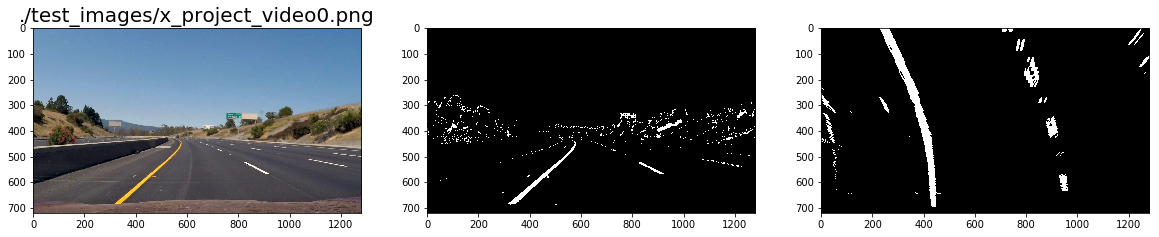

In [70]:
s_thresh=(150, 255)
sx_thresh=(40, 120)
l_thresh = (40, 255)
labl = (0,95,155)
labh = (255,160,255)


try_config('./test_images/x_project_video0.png')
#try_config('./test_images/test*')

In [ ]:
s_thresh=(180, 255)
sx_thresh=(40, 120)
l_thresh=(40, 255)

labl = (0,95,155)
labh = (255,160,255)


try_config('./test_images/*')
#try_config('./test_images/test*')

In [ ]:
def adjust_gamma(image, gamma=1.0):
    # build a lookup table mapping the pixel values [0, 255] to
    # their adjusted gamma values
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
 
    # apply gamma correction using the lookup table
    return cv2.LUT(image, table)

In [ ]:
img = cv2.imread('test_images/test1.jpg')
#img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

#img = adjust_gamma(img, gamma=2)
img = equalize(img)

plt.figure(figsize=(20, 20))
#plt.imshow(img)
plt.imshow(img)
#plt.imshow(eq_image)
#cv2.imwrite('test_images/x_harder_challenge_video24.2.bis.png', img)

In [ ]:
#Code for hsv filter
yl=( 18, 100, 50)
yh=( 25, 255, 255)
hsv = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
low_threshold   = np.array(yl, dtype=np.uint8, ndmin=1)
high_threshold  = np.array(yh, dtype=np.uint8, ndmin=1)

yellow_mask = cv2.inRange(hsv, low_threshold, high_threshold)
yellow_binary = np.full_like(scaled_sobel,1)
yellow_binary = cv2.bitwise_and(yellow_binary,yellow_binary, mask=yellow_mask)
yx = yellow_binary
    
    